#### Author: Erinç Ada Ceylan
#### Company: Wellztech A.Ş.
#### Date: 2024-12-11
#### Description: Time Series Forecasting for Livestock Feeding Parameter Optimization and Cross Validation

In [ ]:
#please first look at the LSTM Final Model.ipynb to understand this code

In [2]:
#imports


import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import datetime
import os
import shutil
import keras_tuner as kt

2024-12-11 22:07:50.642525: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 22:07:50.668900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 22:07:50.698040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 22:07:50.707498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 22:07:50.740618: I tensorflow/core/platform/cpu_feature_guar

In [3]:
#checking whether GPU is working or not. bayesian optimization requires a good GPU for a faster search.

print("TensorFlow version:", tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)
if len(physical_devices) > 0:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(physical_devices)} GPU(s) are available for use.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found, using CPU.")

TensorFlow version: 2.17.0
Available GPUs: []
No GPUs found, using CPU.


I0000 00:00:1733944075.006813  102663 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-11 22:07:55.234383: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
# explained in LSTM Final Model.ipynb

data = pd.read_csv("consecutive_feed.csv")
df = data[["SAMAN", "ARPA", "SLAJ", "YEM", "SU"]]
for col in df.columns:
    df[col + '_derivative'] = np.gradient(df[col])

var_to_guess_1 = "YEM"
var_to_guess_2 = "ARPA"
WINDOW_SIZE = 3

def df_to_X_y(df, var1, var2, window_size):
    df_np = df.to_numpy()
    X, y = [], []
    var1_idx = df.columns.get_loc(var1)
    var2_idx = df.columns.get_loc(var2)
    for i in range(len(df) - window_size):
        X.append(df_np[i:i + window_size, :])
        y.append([df_np[i + window_size, var1_idx], df_np[i + window_size, var2_idx]])
    return np.array(X), np.array(y)

split_1, split_2 = int(0.8 * len(df)), int(0.9 * len(df))
df_train, df_val, df_test = df[:split_1], df[split_1:split_2], df[split_2:]
scalers = {col: MinMaxScaler() for col in df.columns}

def scale_data(df, scalers):
    scaled_df = pd.DataFrame()
    for col in df.columns:
        scaler = scalers[col]
        scaled_df[col] = scaler.fit_transform(df[[col]]).ravel()
    return scaled_df

scaled_train = scale_data(df_train, scalers)
scaled_val = scale_data(df_val, scalers)
scaled_test = scale_data(df_test, scalers)


X_train, y_train = df_to_X_y(scaled_train, var_to_guess_1, var_to_guess_2, WINDOW_SIZE)
X_val, y_val = df_to_X_y(scaled_val, var_to_guess_1, var_to_guess_2, WINDOW_SIZE)
X_test, y_test = df_to_X_y(scaled_test, var_to_guess_1, var_to_guess_2, WINDOW_SIZE)

In [5]:
# the general logic of the model explained in actual_model.ipynb
# for bayesian optimization model is implemented into a function
# if one wants to try a different model, they can change isndide and the inputs of the function


def build_model(window_size, input_dim, dropout_rate=0.1, l2_reg=0.001, learning_rate=0.005):
    model = Sequential([
        InputLayer(input_shape=(window_size, input_dim)),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        LSTM(32, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(16, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dense(2, activation='linear')
    ])
    model.compile(
        loss='huber', #has been picked with tensorboard tuning before
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[RootMeanSquaredError()] #has been picked with tensorboard tuning before
    )
    return model

In [ ]:
# Defining a function to build an LSTM model with configurable hyperparameters.
# It uses Huber loss, Adam optimizer, and RMSE as a metric. Which have been picked with tensorboard tuning before.

def build_model(window_size, input_dim, dropout_rate=0.1, l2_reg=0.001, learning_rate=0.005):
    model = Sequential([
        InputLayer(input_shape=(window_size, input_dim)),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        LSTM(32, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(16, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dense(2, activation='linear')
    ])
    model.compile(
        loss='huber', 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[RootMeanSquaredError()]
    )
    return model


# Building the initial model with default hyperparameters.
model_initial = build_model(WINDOW_SIZE, X_train.shape[2])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=2, min_lr=1e-7)

# Defining a log directory for TensorBoard for monitoring the training process
# TensorBoard callback for visualizing metrics and model training progress.
log_dir = "logs/initial_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Training the model with training and validation data, using callbacks for optimization and monitoring.
history_initial = model_initial.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=1000, 
    batch_size=32, 
    callbacks=[early_stopping, reduce_lr, tensorboard_callback]
)

test_loss_initial, test_rmse_initial = model_initial.evaluate(X_test, y_test)
X_all_initial = np.concatenate([X_train, X_val, X_test], axis=0)
y_pred_initial = model_initial.predict(X_all_initial)

# Function to define a hyperparameter-tuning model for Keras Tuner.
def model_builder(hp):
    # Defining hyperparameters for tuning: window size, dropout rate, L2 regularization, learning rate, and batch size.
    window_size = hp.Int('window_size', min_value=3, max_value=10, step=1)
    dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)
    l2_reg = hp.Float('l2_reg', 1e-5, 1e-2, sampling='log')
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    batch_size = hp.Choice('batch_size', [16, 32, 64])
    
    # Preparing datasets for hyperparameter tuning with adjusted window sizes.
    X_train_tuned, y_train_tuned = df_to_X_y(scaled_train, var_to_guess_1, var_to_guess_2, window_size)
    X_val_tuned, y_val_tuned = df_to_X_y(scaled_val, var_to_guess_1, var_to_guess_2, window_size)
    
    # Building the model using the given hyperparameters.
    model = build_model(
        window_size=window_size,
        input_dim=X_train_tuned.shape[2],
        dropout_rate=dropout_rate,
        l2_reg=l2_reg,
        learning_rate=learning_rate
    )
    model.fit(
        X_train_tuned, y_train_tuned,
        validation_data=(X_val_tuned, y_val_tuned),
        epochs=100,
        batch_size=batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        verbose=0
    )
    return model

# Setting up the logging directory for hyperparameter tuning process.
tuner_log_dir = "logs/hparam_tuning/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(tuner_log_dir, exist_ok=True)

# Configuring the Keras Tuner for Bayesian optimization with 20 trials.
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=20,
    directory='keras_tuner_dir',
    project_name='lstm_tuning'
)

# Loading TensorBoard for monitoring the tuning process.
%load_ext tensorboard 
%tensorboard --logdir logs/hparam_tuning
tuner.search_space_summary()

# Running the hyperparameter search with training and validation data.
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[TensorBoard(log_dir=tuner_log_dir)]
)

# Retrieving the best hyperparameters from the tuning process.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
window_size = best_hps.get('window_size')
dropout_rate = best_hps.get('dropout_rate')
l2_reg = best_hps.get('l2_reg')
learning_rate = best_hps.get('learning_rate')
batch_size = best_hps.get('batch_size')


Trial 13 Complete [00h 00m 41s]
val_loss: 0.0208367221057415

Best val_loss So Far: 0.002604259643703699
Total elapsed time: 00h 09m 33s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
3                 |5                 |window_size
0.2               |0.3               |dropout_rate
0.0052783         |0.00071267        |l2_reg
0.01              |0.01              |learning_rate
64                |64                |batch_size

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0058 - root_mean_squared_error: 0.0885 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1950
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0072 - root_mean_squared_error: 0.1002 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1851
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0075 - root_mean_squared_error: 0.1013 - val_loss: 0.0242 - val_root_mean_squared_error: 0.2067
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 

In [ ]:
# This code performs cross-validation on the full dataset using TimeSeriesSplit for temporal data.
# The goal is to validate the model's generalization across different splits of the time series data.
# For each fold, a new LSTM model is trained and evaluated, and predictions are stored for final analysis.

scaled_df = pd.concat([scaled_train, scaled_val, scaled_test], ignore_index=True)  
X_full, y_full = df_to_X_y(scaled_df, var_to_guess_1, var_to_guess_2, window_size)

tscv = TimeSeriesSplit(n_splits=5)  # TimeSeriesSplit ensures temporal order is preserved during cross-validation.
cv_scores = []  # List to store RMSE scores for each fold.
y_pred_cv_full = np.zeros_like(y_full)  # Array to store predictions across all folds.

for fold, (train_index, test_index) in enumerate(tscv.split(X_full)):
    X_train_cv, X_test_cv = X_full[train_index], X_full[test_index]
    y_train_cv, y_test_cv = y_full[train_index], y_full[test_index] 
    model_cv = build_model(  # Build the model with the optimal hyperparameters.
        window_size=window_size,
        input_dim=X_full.shape[2],
        dropout_rate=dropout_rate,
        l2_reg=l2_reg,
        learning_rate=learning_rate
    )

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=0)  
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)  

    model_cv.fit(  # Train the model on the training data for the current fold.
        X_train_cv, y_train_cv,
        validation_data=(X_test_cv, y_test_cv),
        epochs=1000,
        batch_size=batch_size,
        callbacks=[reduce_lr, early_stopping],
        verbose=0  # verbose=0 means there is no output to display during training.
    )

    loss_cv, rmse_cv = model_cv.evaluate(X_test_cv, y_test_cv, verbose=0)  # Evaluate the model on the test set for the current fold.
    cv_scores.append(rmse_cv)  # Append the RMSE score for this fold to the list.

    y_pred_cv = model_cv.predict(X_test_cv)  # Generate predictions for the test set in the current fold.
    y_pred_cv_full[test_index] = y_pred_cv  # Store predictions in the corresponding indices for the full dataset.


/home/erincada/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/stepWARNING:tensorflow:6 out of the last 21 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f719f5f1990> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


In [ ]:
# Final training and evaluation of the best model using combined training and validation data.
X_train_best = np.concatenate([X_train, X_val], axis=0)  # Combine train and validation sets for final training.
y_train_best = np.concatenate([y_train, y_val], axis=0)
X_test_best, y_test_best = df_to_X_y(scaled_test, var_to_guess_1, var_to_guess_2, window_size)  # Prepare test data.

# Build the LSTM model with optimal hyperparameters.
model_best = build_model(
    window_size=window_size,
    input_dim=X_train_best.shape[2],
    dropout_rate=dropout_rate,
    l2_reg=l2_reg,
    learning_rate=learning_rate
)

# Callbacks for learning rate adjustment and early stopping.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Setup TensorBoard logging.
log_dir_best = "logs/best_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_best, exist_ok=True)
tensorboard_callback_best = TensorBoard(log_dir=log_dir_best, histogram_freq=1)

# Train the model on the full training set and validate on the test set.
history_best = model_best.fit(
    X_train_best, y_train_best,
    validation_data=(X_test_best, y_test_best),
    epochs=1000,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping, tensorboard_callback_best],
    verbose=1
)

# Evaluate the model on the test set and generate predictions.
test_loss_best, test_rmse_best = model_best.evaluate(X_test_best, y_test_best)
X_all_best = np.concatenate([X_train_best, X_test_best], axis=0)  # Combine all data for final predictions.
y_pred_best = model_best.predict(X_all_best)

Epoch 1/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1591 - root_mean_squared_error: 0.4329 - val_loss: 0.0685 - val_root_mean_squared_error: 0.2488 - learning_rate: 0.0100
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0418 - root_mean_squared_error: 0.1305 - val_loss: 0.0495 - val_root_mean_squared_error: 0.2316 - learning_rate: 0.0100
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0271 - root_mean_squared_error: 0.1134 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2281 - learning_rate: 0.0100
Epoch 4/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0203 - root_mean_squared_error: 0.1099 - val_loss: 0.0383 - val_root_mean_squared_error: 0.2321 - learning_rate: 0.0100
Epoch 5/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0163 - root_mean_squared_error: 0.1074 - val_loss: 0.0366 - val_root_mean_squared_error: 0.2372 - learning_rate: 0.0100
Epoch 6/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0132 - root_mean_squar

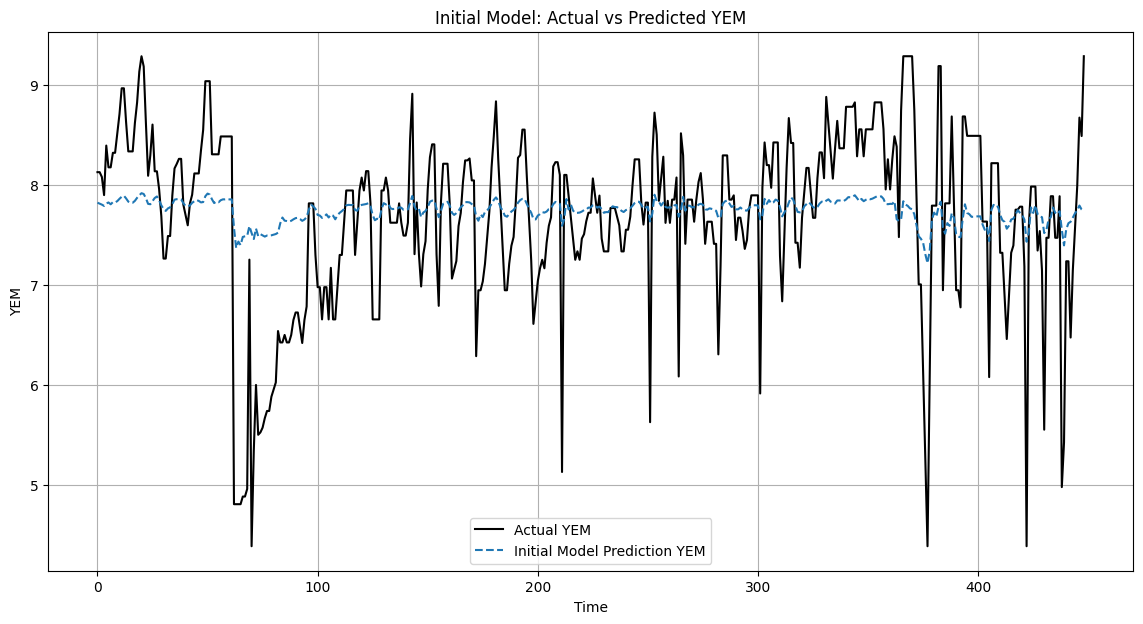

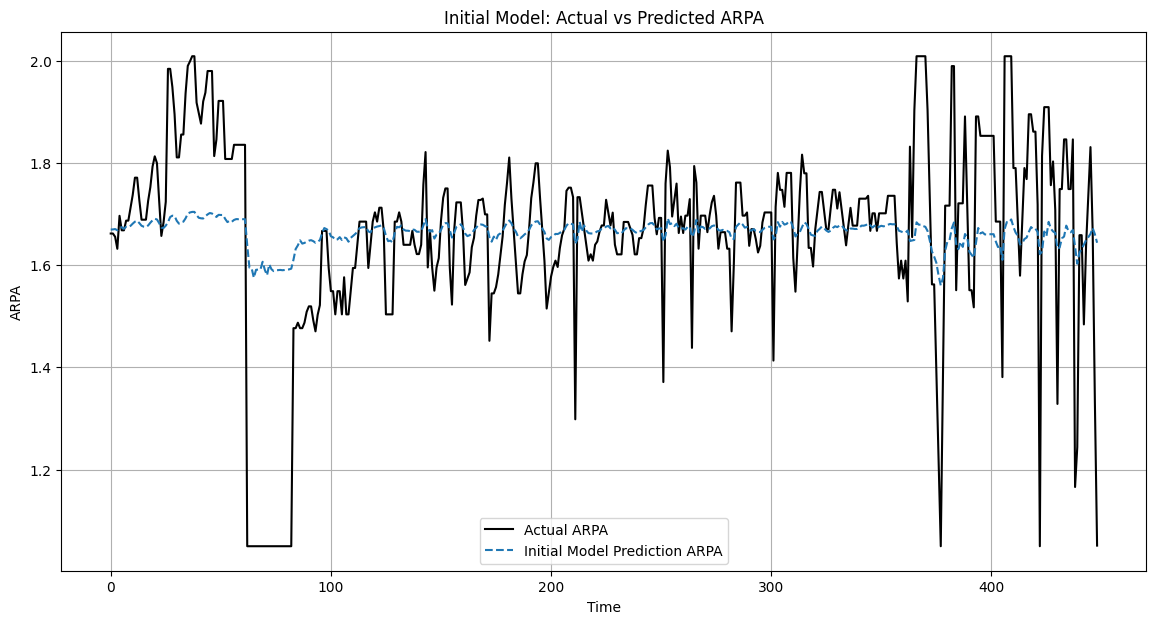

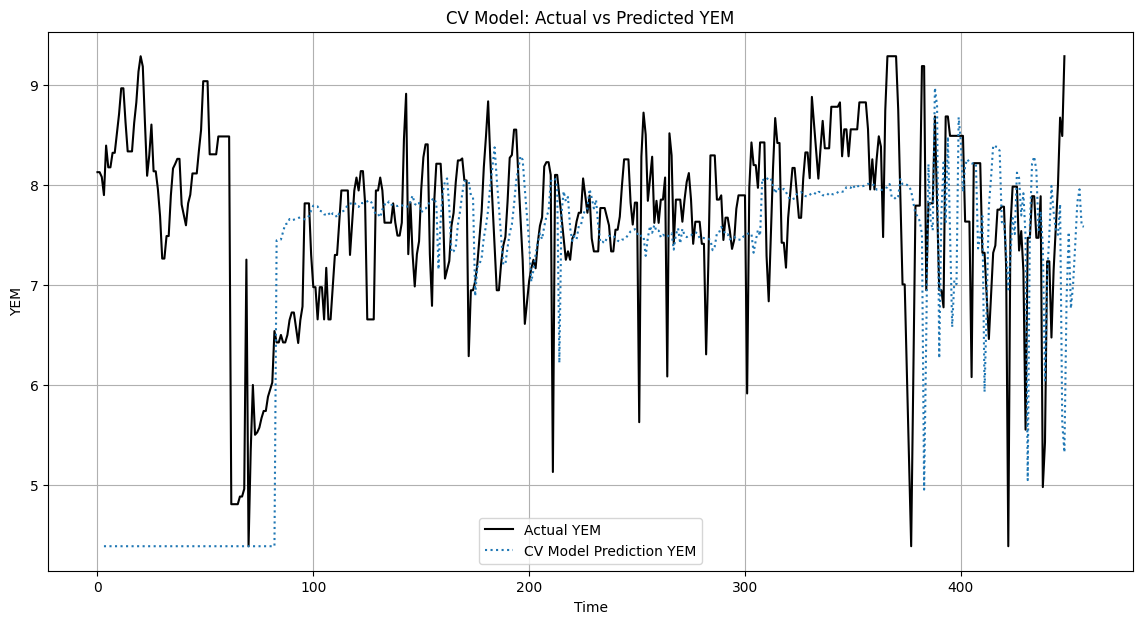

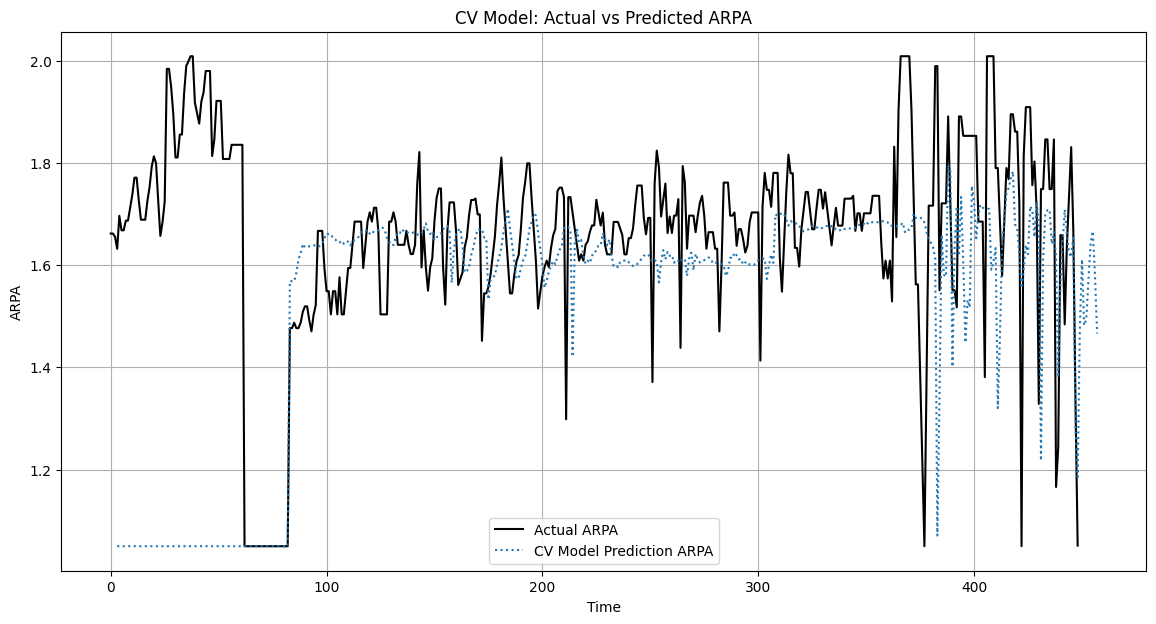

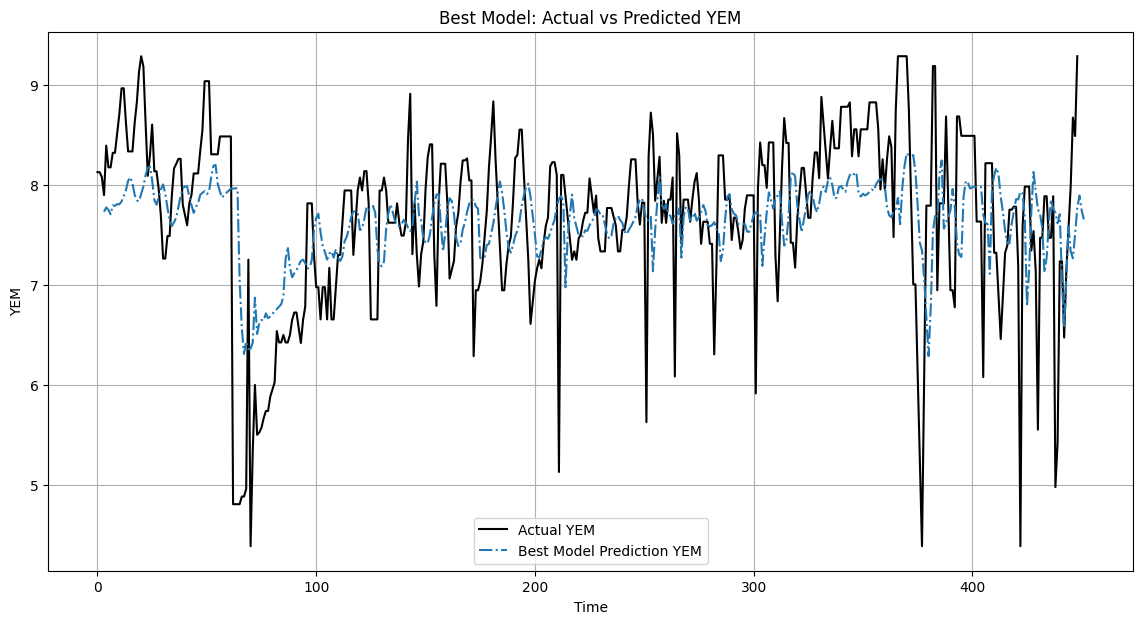

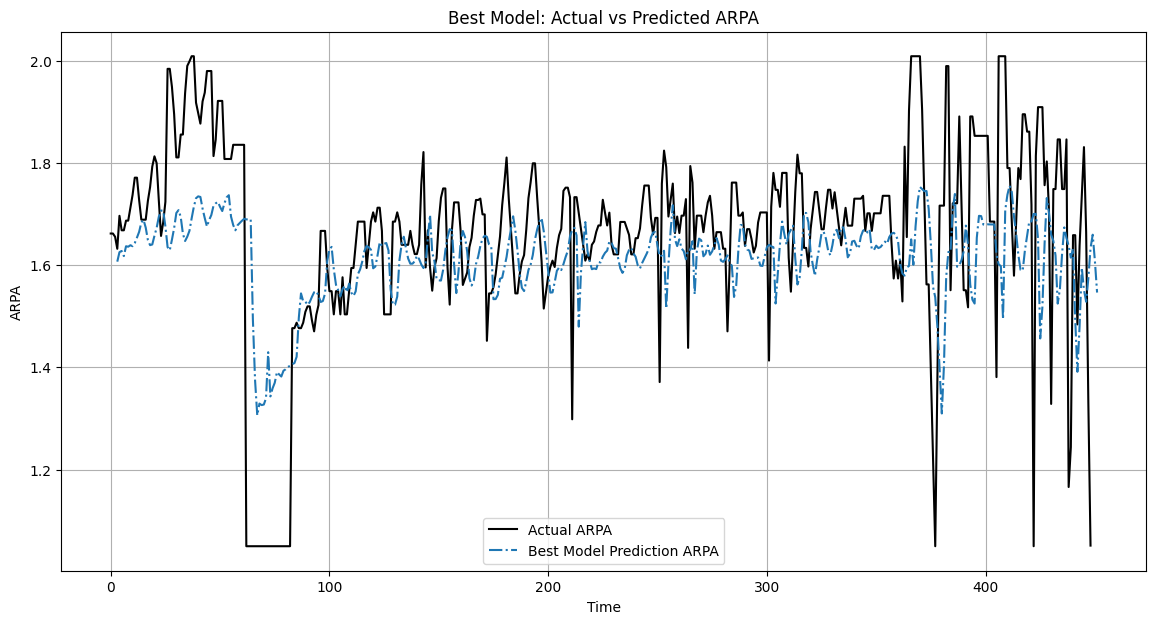

In [ ]:
def inverse_transform(y_scaled, scaler):
    y_inv = scaler.inverse_transform(y_scaled.reshape(-1,1)).ravel()
    return y_inv

# Inverse transform the predictions and actual values
y_pred_initial_inv_var1 = inverse_transform(y_pred_initial[:,0], scalers[var_to_guess_1])
y_pred_initial_inv_var2 = inverse_transform(y_pred_initial[:,1], scalers[var_to_guess_2])

y_pred_best_inv_var1 = inverse_transform(y_pred_best[:,0], scalers[var_to_guess_1])
y_pred_best_inv_var2 = inverse_transform(y_pred_best[:,1], scalers[var_to_guess_2])

y_pred_cv_inv_var1 = inverse_transform(y_pred_cv_full[:,0], scalers[var_to_guess_1])
y_pred_cv_inv_var2 = inverse_transform(y_pred_cv_full[:,1], scalers[var_to_guess_2])

# Inverse transform the full actual values
y_full_all = np.concatenate([y_train, y_val, y_test], axis=0)
y_full_inv_var1 = inverse_transform(y_full_all[:,0], scalers[var_to_guess_1])
y_full_inv_var2 = inverse_transform(y_full_all[:,1], scalers[var_to_guess_2])

# Plot 1: Initial Model Prediction vs Actual
plt.figure(figsize=(14, 7))
plt.plot(y_full_inv_var1, label=f"Actual {var_to_guess_1}", color='black')
plt.plot(y_pred_initial_inv_var1, label=f"Initial Model Prediction {var_to_guess_1}", linestyle='--')
plt.xlabel('Time')
plt.ylabel(var_to_guess_1)
plt.title(f"Initial Model: Actual vs Predicted {var_to_guess_1}")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_full_inv_var2, label=f"Actual {var_to_guess_2}", color='black')
plt.plot(y_pred_initial_inv_var2, label=f"Initial Model Prediction {var_to_guess_2}", linestyle='--')
plt.xlabel('Time')
plt.ylabel(var_to_guess_2)
plt.title(f"Initial Model: Actual vs Predicted {var_to_guess_2}")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: CV Model Prediction vs Actual
plt.figure(figsize=(14, 7))
plt.plot(y_full_inv_var1, label=f"Actual {var_to_guess_1}", color='black')
plt.plot(range(window_size, len(y_pred_cv_inv_var1) + window_size), y_pred_cv_inv_var1, label=f"CV Model Prediction {var_to_guess_1}", linestyle=':')
plt.xlabel('Time')
plt.ylabel(var_to_guess_1)
plt.title(f"CV Model: Actual vs Predicted {var_to_guess_1}")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_full_inv_var2, label=f"Actual {var_to_guess_2}", color='black')
plt.plot(range(window_size, len(y_pred_cv_inv_var2) + window_size), y_pred_cv_inv_var2, label=f"CV Model Prediction {var_to_guess_2}", linestyle=':')
plt.xlabel('Time')
plt.ylabel(var_to_guess_2)
plt.title(f"CV Model: Actual vs Predicted {var_to_guess_2}")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Best Model Prediction vs Actual
plt.figure(figsize=(14, 7))
plt.plot(y_full_inv_var1, label=f"Actual {var_to_guess_1}", color='black')
plt.plot(range(window_size, len(y_pred_best_inv_var1) + window_size), y_pred_best_inv_var1, label=f"Best Model Prediction {var_to_guess_1}", linestyle='-.')
plt.xlabel('Time')
plt.ylabel(var_to_guess_1)
plt.title(f"Best Model: Actual vs Predicted {var_to_guess_1}")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_full_inv_var2, label=f"Actual {var_to_guess_2}", color='black')
plt.plot(range(window_size, len(y_pred_best_inv_var2) + window_size), y_pred_best_inv_var2, label=f"Best Model Prediction {var_to_guess_2}", linestyle='-.')
plt.xlabel('Time')
plt.ylabel(var_to_guess_2)
plt.title(f"Best Model: Actual vs Predicted {var_to_guess_2}")
plt.legend()
plt.grid(True)
plt.show()

# Clean up created directories
shutil.rmtree('logs', ignore_errors=True)
shutil.rmtree('keras_tuner_dir', ignore_errors=True)


In [ ]:
# En iyi parametreleri print etme
print(f"Best Hyperparameters found from Bayesian Optimization:")
print(f"Window Size: {best_hps.get('window_size')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"L2 Regularization: {best_hps.get('l2_reg')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Batch Size: {best_hps.get('batch_size')}")


Best Hyperparameters found from Bayesian Optimization:
Window Size: 3
Dropout Rate: 0.0
L2 Regularization: 0.000624260277788991
Learning Rate: 0.01
Batch Size: 16
